# Rețea neuronală de clasificare a imaginilor

Acest notebook demonstrează implementarea unei rețele neuronale convoluționale cu scopul de a clasifica imaginile ca având în ele fețe umane sau altceva. Modelul nu încearcă decât marcarea unei imagini ca având o față umană în ea. Nu va putea detecta mai multe fețe în imagine și toleranța pentru dimensiunea feței față de dimensiunea totală a imaginii depinde de setul de imagini de antrenament.

In [1]:
import google.colab
google.colab.drive.mount('/content/gdrive/', force_remount=True)
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.ndimage import grey_dilation
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from google.colab import files
from IPython.display import display


Mounted at /content/gdrive/


In [2]:
data_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/DATA/train_classifier'
model_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/Models/Face/Elementary_classifier'

Verificăm dacă există directoarele cu date

In [3]:
if os.path.isdir(data_dir):
  print("Data directory exists")
else:
  print("Data directory does not exist")
if os.path.isdir(model_dir):
  print("Model directory exists")
else:
  print("Model directory does not exist")

Data directory exists
Model directory exists


Calculele se pot face fie pe un dispozitiv grafic (cuda) fie pe un procesor normal (cpu). Urmatoarea linie de cod detecteaza dispozitivul.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(DEVICE)

cuda


## Funcția de transformare

Functiile de transformare sunt utile pentru pregatirea imaginilor inainte de a le introduce in reteaua neuronala. Orice retea neuronala este configurata sa primeasca o dimensiune de imagini estrem de precisa. In plus, functiile de transformare pot aplica si modificari de substanta: crestere de cotnrast, etc.

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Definirea setului de date

**Setul de date (Dataset)**: Aceasta este clasa responsabilă pentru reprezentarea și accesul la date. Aceasta trebuie să fie o subclasă a clasei torch.utils.data.Dataset și să implementeze metodele __len__ și __getitem__. În metoda __getitem__, se obțin datele corespunzătoare unui anumit index, de obicei returnând o pereche de intrare (exemplu) și etichetă.

In [6]:
class FaceDataset(Dataset):
    def __init__(self, image_dir, positive_prefix, transform=None):
        self.image_dir = image_dir
        self.positive_prefix = positive_prefix
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg'))]
        self.labels = [1 if self.positive_prefix in image_path else 0 for image_path in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label


## Definirea retelei neuronale propriu-zise

In [7]:
class CNNClassifier(nn.Module):
    def __init__(self, image_size = 128, embedding_size=512):
        super(CNNClassifier, self).__init__()
        self.image_size = image_size

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(131072, embedding_size),  # Fully connected layer after conv layers
            nn.ReLU(),
            nn.Linear(embedding_size, 1),  # Output for binary classification
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = self.fc_layers(x)  # Pass through fully connected layers
        return x

## Inițializarea setului de date și a loaderului

In [10]:
train_dataset = FaceDataset(
    image_dir=data_dir,
    transform=transform,
    positive_prefix='face')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

## Dimensiunea penultimului strat (embedding)

Embedding reprezintă penultimul strat (cel care este direct conectat cu stratul final de clasificare). Dimensiunea acestuia poate fi modificata.

In [11]:
embedding_size=512

## Inițializarea modelului si a functiei de cost

folosim ca funcție de cost Binary Cross Entropy Loss

Funcția de cost Binary Cross Entropy este utilizată în probleme de clasificare binară, unde modelul trebuie să decidă între două clase posibile (de exemplu, 0 sau 1). Această funcție măsoară diferența dintre valorile prezise de model (sub formă de probabilități între 0 și 1) și valorile reale (etichetă 0 sau 1). Ea penalizează mai sever predicțiile care sunt departe de adevăr; de exemplu, dacă modelul prezice o probabilitate de 0.9 pentru clasa 1, dar eticheta reală este 0, penalizarea va fi mare. Binary Cross Entropy calculează o medie a pierderilor pentru fiecare exemplu din setul de date și returnează o valoare scalară, care este apoi folosită de optimizator pentru a ajusta parametrii modelului.

In [12]:
model = CNNClassifier(embedding_size=embedding_size).to(DEVICE)
criterion = torch.nn.BCELoss().to(DEVICE)  # Binary Cross Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

În contextul antrenării unui model de învățare automată, un **epoch** reprezintă o trecere completă prin întregul set de date de antrenament. Asta înseamnă că, pentru fiecare epoch, modelul va procesa fiecare exemplu din setul de date o singură dată, calculând predicțiile și actualizând parametrii folosind algoritmul de optimizare.

De obicei, un model necesită mai multe epoci pentru a învăța și a ajusta corect parametrii săi, deoarece un singur pas nu este suficient pentru a ajunge la o performanță optimă. În fiecare epoch, modelul își îmbunătățește treptat predicțiile, reducând eroarea (pierderea) în timp.

In [13]:
num_epochs = 10

## Codul de antrenament

Antrenamentul implică trecerea tuturor imaginilor prin rețeaua neuronală si modificarea treptată a parametrilor acesteia până când predicțiile acesteia se apropie foarte mult de adevăr.

Codul de antrenament are o serie de particularități care depinde de modul în care exte implementat pytorch.


În PyTorch, chiar dacă în liniile de cod loss.backward() și optimizer.step() nu se menționează explicit modelul, PyTorch știe automat ce să facă datorită modului în care funcționează autograd, motorul de diferențiere automată. În momentul în care se calculează pierderea (loss), PyTorch creează un graf computațional care urmărește toate operațiile realizate cu parametrii modelului (ponderi, biases), stocând aceste informații. Astfel, atunci când se apelează loss.backward(), PyTorch utilizează acest graf pentru a calcula automat derivatele (gradienții) pierderii în raport cu parametrii modelului. De asemenea, când se apelează optimizer.step(), optimizatorul folosește acești gradienți pentru a actualiza parametrii modelului, fără a fi necesar să fie specificat modelul în mod direct.

Totul se întâmplă deoarece PyTorch știe, datorită grafului computațional, ce parametri ai modelului au contribuit la calculul pierderii, și cum aceștia trebuie actualizați pentru a minimiza pierderea.


In [14]:
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i = 1
    for inputs, labels in train_loader:
        # copiem datele si etichetele in memoria device-ului care execută codul de antrenament
        inputs,labels = inputs.to(DEVICE), labels.to(DEVICE)
        # transformăm etichetele (0 - non-față, 1 - față) în numere flotante - acestea sunt necesare pentru funcția de cost BCE
        labels = labels.float().view(-1, 1)
        # resetarea gradienților optimizatorului inainte de noua trecere prin model
        optimizer.zero_grad()

        #trecem imaginile prin model
        outputs = model(inputs)

        #calculam diferenta dintre predicțiile modelului și realitate (labels)
        loss = criterion(outputs, labels)

        # urmatoarele doua linii de cod functioneaza impreuna. loss.backward() si optimnizer.step()
        # modifica parametrii modelului astfel incât urmatoarea predictie sa se apropie mai mult de adevăr
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        #print(f"       BATCH = {i}/{len(train_loader)} Loss: {running_loss/len(train_loader)}")
        i = i + 1
    losses.append(running_loss/len(train_loader))
    print(f"===>> Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    torch.save(model.state_dict(), os.path.join(model_dir, f"trained_classifier_{embedding_size}_{epoch}.pth"))

KeyboardInterrupt: 

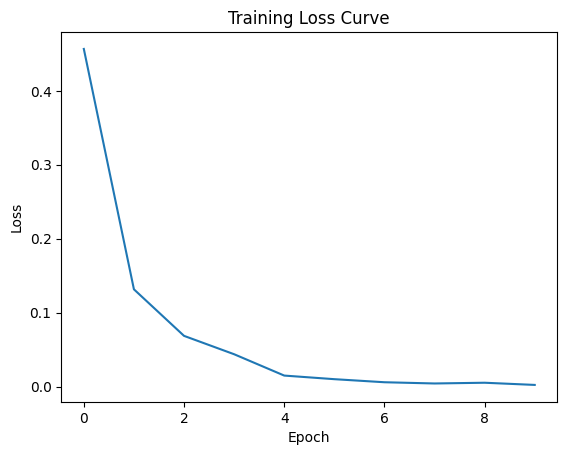

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [15]:
test_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/DATA/test_classifier'

In [18]:
embedding_size_test = 128
epoch = 9
model = CNNClassifier(embedding_size=embedding_size_test).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(model_dir, f"trained_classifier_{embedding_size_test}_{epoch}.pth")))
model.eval()  # Set the model to evaluation mode

CNNClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

## Testarea modelului cu datele de test

Afisarea rezultatelor urmareste cateva elemente. In primul rand calitatea detectie, exprimata sub forma a 4 parametrii:

- Pozitive corecte - detectii pozitive corecte (fete in imagine)
- Negative corecte - detectii negative corecte (lipsa fetelor in imagini)
- Falsuri pozitive - modelul a detectat o fata acolo unde nu exista
- falsuri negative - modelul a detectat o imagine care NU este fata, acolo unde aceasta in realitate exista

In [19]:
true_labels = []
predictions = []

for label, subdir in zip([1, 0], ['positive', 'negative']):
    dir_path = os.path.join(test_dir, subdir)

    for img_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, img_name)
        if img_path.endswith(('png', 'jpg', 'jpeg')):

            test_img = Image.open(img_path) # Citeste imaginea
            test_img_converted = test_img.convert("RGB")  # Converteste la RGB
            test_img_transformed = transform(test_img_converted)  # Aplica functia de transformare
            test_img_transformed = test_img_transformed.to(DEVICE)  # Mutam datele catre dispozitivul curent
            test_img_transformed = test_img_transformed.unsqueeze(0)  # Adaugam dimensiunea de grup

            outputs = model(test_img_transformed) # Trecem imaginea prin model
            predictions_score = torch.sigmoid(outputs).squeeze()  # Obtinem probabilitatile

            # Threshold 0.6 pentru a discrimina intre fete si non-fete (0: fata, 1: nu este fata)
            predicted_label = (predictions_score > 0.6).float()

            true_labels.append(label)
            predictions.append(predicted_label.item())

            print(f"gImage: {img_name} | True label: {'face' if label == 1 else 'no face'} | Predicted: {'face' if predicted_label > 0.6 else 'no face'} | Confidence: {predictions_score:.2f}")

# Calculam matricea de confuzie
conf_matrix = metrics.confusion_matrix(true_labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)

gImage: 045002.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045001.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045032.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045019.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045031.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045020.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045024.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045017.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045043.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045048.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045054.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045052.jpg | True label: face | Predicted: face | Confidence: 0.73
gImage: 045072.jpg | True label: face | Predicted: face | Confidence: 0.72
gImage: 045075.jpg | True

## Testarea modelului cu o imagine incarcata direct

Executati celula urmatoare si cele care urmeaza pentru a testa o noua imagine.

In [23]:
from google.colab import files
from IPython.display import display

print("Incarcati o imagine de test")
uploaded_test_image = files.upload()  # Allows user to upload a file
# Get the first uploaded file
uploaded_test_image_path = list(uploaded_test_image.keys())[0]

Incarcati o imagine de test


Saving 287214129_4966898600099008_4985397726108728003_n.jpg to 287214129_4966898600099008_4985397726108728003_n.jpg


In [24]:
test_img = Image.open(uploaded_test_image_path)
display(test_img)



Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Verifica daca imaginea are trei canale (RGB)
print(test_img.mode)
if test_img.mode != "RGB":
    print(f"Skipping {uploaded_test_image_path}: Image has {len(test_img.getbands())} channels (expected at least 3).")
else:
  test_img_converted = test_img.convert("RGB")
  test_img_transformed = transform(test_img_converted)
  test_img_transformed = test_img_transformed.to(DEVICE)
  test_img_transformed = test_img_transformed.unsqueeze(0)
  print(test_img_transformed.shape)
  outputs = model(test_img_transformed)
  predictions = torch.sigmoid(outputs).squeeze()
  predicted_labels = (predictions > 0.6).float()
  print(predicted_labels)
  if predicted_labels < 0.6:
    print("Imaginea nu contine o față")
  else:
    print("imaginea contine o fata")

RGB
torch.Size([1, 3, 128, 128])
tensor(0., device='cuda:0')
Imaginea nu contine o față
